In [3]:
%matplotlib inline
from utils import *
import io_utils as io
import vis_utils as vis
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from scipy.stats import beta, expon, truncnorm, norm, uniform
from scipy.sparse.linalg import lsqr
from scipy.optimize import minimize
from time import process_time
from functools import reduce
from pandas import ExcelWriter
from pandas import ExcelFile
import xlrd
import re
import copy
from matplotlib import cm

pd.options.display.float_format = '{:,g}'.format
plt.style.use(['ggplot'])

In [4]:
config = io.read_tephra2_config("data/colima/colima_config.txt")

globs = {
    "LITHIC_DIAMETER_THRESHOLD": 7.,
    "PUMICE_DIAMETER_THRESHOLD": -1.,
    "AIR_VISCOSITY": 0.000018325,
    "AIR_DENSITY":  1.293,
    "GRAVITY": 9.81,
}






# Update parameters
# COL STEPS need to be small enough so the 
# layer height can be kept for an inversion with a high H
config["COL_STEPS"] = 20
theoretical_max = 45000 #The H value will be as close as possible to this
layer_thickness = ((config["PLUME_HEIGHT"]-config["VENT_ELEVATION"])/config["COL_STEPS"])

inversion_steps = np.round((config["COL_STEPS"]*(theoretical_max - config["VENT_ELEVATION"]))/\
                  (config["PLUME_HEIGHT"]-config["VENT_ELEVATION"]))
closest_H = ((inversion_steps*(config["PLUME_HEIGHT"] - config["VENT_ELEVATION"]))/\
             config["COL_STEPS"]) + config["VENT_ELEVATION"]
print("This number needs to be low enough to invert efficiently:")
print(inversion_steps)
print("If not, decrease COL_STEPS or theoretical max")
print("Closest Possible Theoretical Max Column Height:")
print(closest_H)

config["INV_STEPS"] = int(inversion_steps)
config["THEO_MAX_COL"] = closest_H
config["PART_STEPS"] = 9

config["MAX_GRAINSIZE"] = -5
config["MIN_GRAINSIZE"] = 4

# Additional parameter: Constant wind speed
config["WIND_SPEED"] = 10

# To ensure monotonicity:
# config["DIFFUSION_COEFFICIENT"] = 1.7*config["FALL_TIME_THRESHOLD"]

print("INPUT PARAMETERS:")
display(config)
display(globs)

This number needs to be low enough to invert efficiently:
40.0
If not, decrease COL_STEPS or theoretical max
Closest Possible Theoretical Max Column Height:
44915.0
INPUT PARAMETERS:


{'VENT_EASTING': 0.0,
 'VENT_NORTHING': 0.0,
 'VENT_ELEVATION': 3085.0,
 'PLUME_HEIGHT': 24000.0,
 'ALPHA': 1.02,
 'BETA': 1.56,
 'ERUPTION_MASS': 55000000000.0,
 'MAX_GRAINSIZE': -5,
 'MIN_GRAINSIZE': 4,
 'MEDIAN_GRAINSIZE': -1.8,
 'STD_GRAINSIZE': 2.4,
 'EDDY_CONST': 0.04,
 'DIFFUSION_COEFFICIENT': 4016.0,
 'FALL_TIME_THRESHOLD': 6458.0,
 'LITHIC_DENSITY': 2700.0,
 'PUMICE_DENSITY': 1024.0,
 'COL_STEPS': 20,
 'PART_STEPS': 9,
 'PLUME_MODEL': 2.0,
 'INV_STEPS': 40,
 'THEO_MAX_COL': 44915.0,
 'WIND_SPEED': 10}

{'LITHIC_DIAMETER_THRESHOLD': 7.0,
 'PUMICE_DIAMETER_THRESHOLD': -1.0,
 'AIR_VISCOSITY': 1.8325e-05,
 'AIR_DENSITY': 1.293,
 'GRAVITY': 9.81}

,Sample no.,Easting,Northing,MassArea,Thickness,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",radius
16,VF0004a,1499,1506,625.8,60,19.2,31,18,11,6,2,1,0.6,0.9,"2,124.86"
18,VF0006a3,1957,1997,417.2,40,6.7,30,25,17,11,5,1,0.8,0.8,"2,796.04"
17,VF0005a3,1787,2173,500.64,48,10.1,30,24,16,9,3,1,0.7,1,"2,813.41"
37,VF0603509,-770,3082,594.51,57,11.3,25,25,19,11,4,1,0.6,0.5,"3,176.73"
31,VF0508a3,-1673,3152,125.16,12,10,22,24,16,10,4,2,0.8,0.8,"3,568.48"
36,VF0518a3,-637,4876,166.88,16,3.1,21,25,22,16,7,2,0.9,0.8,"4,917.43"
35,VF0517a,-1268,5048,125.16,12,9.8,14,17,20,17,10,4,2.1,1.8,"5,204.82"
34,VF0516a3,-2101,5517,93.87,9,4.1,15,19,19,19,12,4,2.6,2.8,"5,903.52"
33,VF0514a3,-2250,5771,62.58,6,0.1,9,13,19,21,14,7,4.6,5.6,"6,194.11"
32,VF0513a,-2272,5925,62.58,6,4.2,9,17,19,17,11,8,5.5,4.2,"6,345.68"


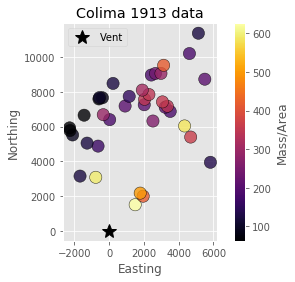

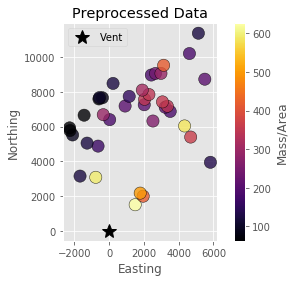

In [7]:
filename = "./data/colima/colima_real_data.csv"

raw_df, grid = io.import_colima(filename)

grid.to_csv("data/colima/colima_grid.csv", sep=" ", header=False, index=False)

display(raw_df)

vis.plot_sample(raw_df, vent=(0,0), log=False, title="Colima 1913 data", cbar_label="Mass/Area")
plt.show()
# plt.savefig("colima/all_points.png", dpi=200, format='png')

obs_df = raw_df.copy()

# obs_df = obs_df.drop([16, 18, 17, 37, 31])
#This is going to be 100 across. Just needs to be the same as the other dfs. 
obs_df["Residual"] = obs_df["MassArea"]/obs_df["MassArea"]*100

vis.plot_sample(obs_df, vent=(0,0), log=False, title="Preprocessed Data", cbar_label="Mass/Area")
# plt.savefig("colima/All_trans.png", dpi=200, format='png')
plt.show()

In [71]:
def col_truncnorm(mean, top=config["THEO_MAX_COL"]):
    bottom = 5000
    std = (top - bottom)/4
    standard_a, standard_b = (bottom - mean) / std, (top - mean) / std
    return truncnorm.rvs(standard_a, standard_b, loc=mean, scale=std)

def lognorm(prior, bottom=0):
    std_norm = norm.rvs()
    std_lognorm = np.exp(std_norm)
    lognorm = bottom + (prior-bottom)*std_lognorm
    return lognorm

def normal(prior):
    std_norm = norm.rvs()
    normal = prior*std_norm
    return normal

def uninformed(bottom, top):
    unif = uniform.rvs(loc = bottom, scale = (top-bottom))
    return unif

param_config = {
    "a": {
        "value":[1.01, 5],
        "invert":True,
        "sample_function": uninformed
    },
    "b": {
        "value":[1.01, 5],
        "invert":True,
        "sample_function": uninformed
    },
    "h1": {
        "value":[5000, config["THEO_MAX_COL"]],
        "invert":True,
        "sample_function": uninformed
    },
    "u": {
        "value":[0, 10],
        "invert":True,
        "sample_function": uninformed
    },
    "v": {
        "value":[0, 10],
        "invert":True,
        "sample_function": uninformed
    },
    "D": {
        "value":[1000, 100000],
        "invert":True,
        "sample_function": uninformed
    },
    "ftt": {
        "value":[config["FALL_TIME_THRESHOLD"], 10000],
        "invert":False,
        "sample_function": uninformed
    },
}

param_config_df = pd.DataFrame(param_config)
display(param_config_df.T)


,invert,sample_function,value
a,True,<function uninformed at 0x000002D6E029BD08>,"[1.01, 5]"
b,True,<function uninformed at 0x000002D6E029BD08>,"[1.01, 5]"
h1,True,<function uninformed at 0x000002D6E029BD08>,"[5000, 44915.0]"
u,True,<function uninformed at 0x000002D6E029BD08>,"[0, 10]"
v,True,<function uninformed at 0x000002D6E029BD08>,"[0, 10]"
D,True,<function uninformed at 0x000002D6E029BD08>,"[1000, 100000]"
ftt,False,<function uninformed at 0x000002D6E029BD08>,"[6458.0, 10000]"


In [112]:
def generate_hypercube_samples(
    sample_size, param_config, data, num_points, column_steps, 
    z_min, z_max, elevation, phi_steps, 
    total_mass, eddy_constant, column_cap
):
    sample_misfit_list = []
    sample_list = []
    # generate list of indices for each parameter
    
    for key, val in param_config.items():
        param_config[key]["subspaces"] = list(range(0, sample_size))
    
    for p in range(sample_size):
        samples = {}
        for key, val in param_config.items():

            if val["invert"]:
                print(key)
                bottom = val["value"][0]
                top = val["value"][1]
                hyperspace = np.linspace(bottom, top, sample_size+1)
                print(hyperspace)
                
                subspace = random.choice(val["subspaces"])
                print(subspace)
                print(hyperspace[subspace], hyperspace[subspace+1])
                samples[key] = val["sample_function"](hyperspace[subspace], hyperspace[subspace+1])
                print(samples[key])
                val["subspaces"].remove(subspace)
            else:
                samples[key] = val["value"][0]
        
        misfit, _, _ = get_error_contributions(
            data, num_points, column_steps, 
            z_min, z_max, elevation, phi_steps, 
            samples, total_mass, eddy_constant=eddy_constant, column_cap=column_cap)

        samples["Misfit"] = misfit
        sample_list += [samples]
        sample_misfit_list += [misfit]
    return sample_list, sample_misfit_list

In [113]:
theo_phi_steps = get_phi_steps(config["MIN_GRAINSIZE"], config["MAX_GRAINSIZE"], 
                          config["PART_STEPS"], 
                          config["MEDIAN_GRAINSIZE"], config["STD_GRAINSIZE"],
                          globs["LITHIC_DIAMETER_THRESHOLD"], 
                          globs["PUMICE_DIAMETER_THRESHOLD"], 
                          config["LITHIC_DENSITY"], config["PUMICE_DENSITY"])

tgsd = get_tgsd(obs_df, theo_phi_steps)
prior_phi_steps = copy.deepcopy(theo_phi_steps)

In [149]:
sample_size = 20
hyp_sample_list, hyp_sample_misfit_list = generate_hypercube_samples(sample_size, param_config, obs_df, len(obs_df), config["COL_STEPS"], 
                           config["VENT_ELEVATION"], 
                           config["THEO_MAX_COL"], 2500, 
                           prior_phi_steps, config["ERUPTION_MASS"],
                           config["EDDY_CONST"], config["THEO_MAX_COL"])

sample_list, sample_misfit_list = generate_param_samples(sample_size, param_config, obs_df, len(obs_df), config["COL_STEPS"], 
                           config["VENT_ELEVATION"], 
                           config["THEO_MAX_COL"], 2500, 
                           prior_phi_steps, config["ERUPTION_MASS"],
                           config["EDDY_CONST"], config["THEO_MAX_COL"])

a
[1.01   1.2095 1.409  1.6085 1.808  2.0075 2.207  2.4065 2.606  2.8055
 3.005  3.2045 3.404  3.6035 3.803  4.0025 4.202  4.4015 4.601  4.8005
 5.    ]
15
4.0025 4.202
4.075965630468824
b
[1.01   1.2095 1.409  1.6085 1.808  2.0075 2.207  2.4065 2.606  2.8055
 3.005  3.2045 3.404  3.6035 3.803  4.0025 4.202  4.4015 4.601  4.8005
 5.    ]
2
1.409 1.6085
1.473870220915603
h1
[ 5000.    6995.75  8991.5  10987.25 12983.   14978.75 16974.5  18970.25
 20966.   22961.75 24957.5  26953.25 28949.   30944.75 32940.5  34936.25
 36932.   38927.75 40923.5  42919.25 44915.  ]
11
26953.25 28949.0
28561.51741959671
u
[ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10. ]
13
6.5 7.0
6.617016290774316
v
[ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10. ]
4
2.0 2.5
2.116217966844192
D
[  1000.   5950.  10900.  15850.  20800.  25750.  30700.  35650.  40600.
  45550.  50500.  55450.  60400.  65350. 

C:\Users\nmostert\Documents\repos\inversion_project\utils.py:445: RuntimeWarning: invalid value encountered in true_divide
  q = (plume/sum(plume))*tot_mass


4.2978123435410795
h1
[ 5000.    6995.75  8991.5  10987.25 12983.   14978.75 16974.5  18970.25
 20966.   22961.75 24957.5  26953.25 28949.   30944.75 32940.5  34936.25
 36932.   38927.75 40923.5  42919.25 44915.  ]
19
42919.25 44915.0
44358.87573493745
u
[ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10. ]
19
9.5 10.0
9.826780022791374
v
[ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10. ]
8
4.0 4.5
4.220649500349042
D
[  1000.   5950.  10900.  15850.  20800.  25750.  30700.  35650.  40600.
  45550.  50500.  55450.  60400.  65350.  70300.  75250.  80200.  85150.
  90100.  95050. 100000.]
3
15850.0 20800.0
16862.25714353871
a
[1.01   1.2095 1.409  1.6085 1.808  2.0075 2.207  2.4065 2.606  2.8055
 3.005  3.2045 3.404  3.6035 3.803  4.0025 4.202  4.4015 4.601  4.8005
 5.    ]
10
3.005 3.2045000000000003
3.172119435071102
b
[1.01   1.2095 1.409  1.6085 1.808  2.0075 2.207  2.4065 2

a


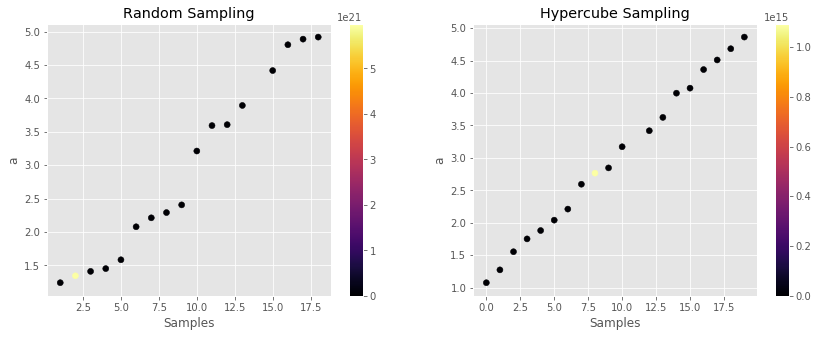

b


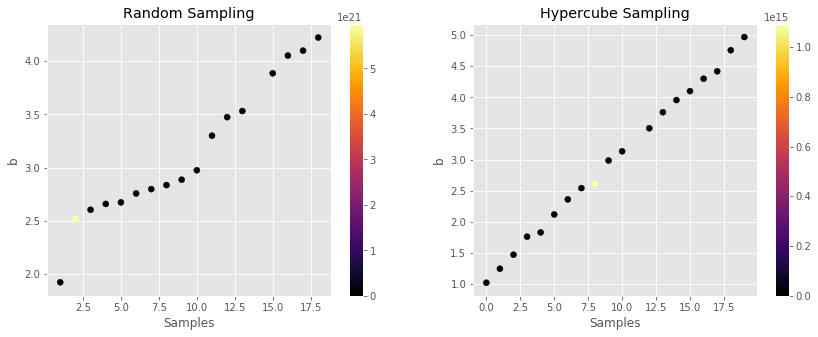

h1


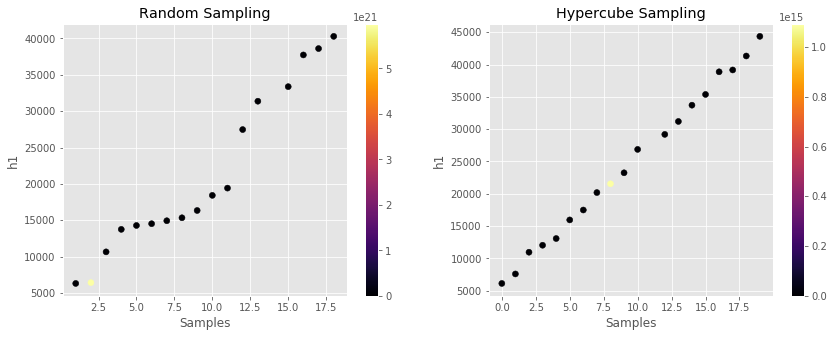

u


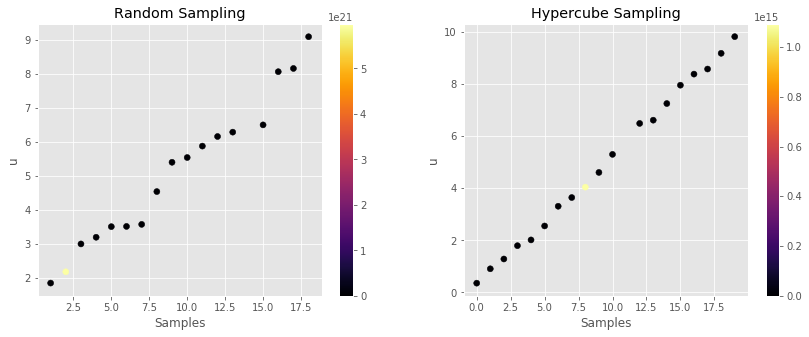

v


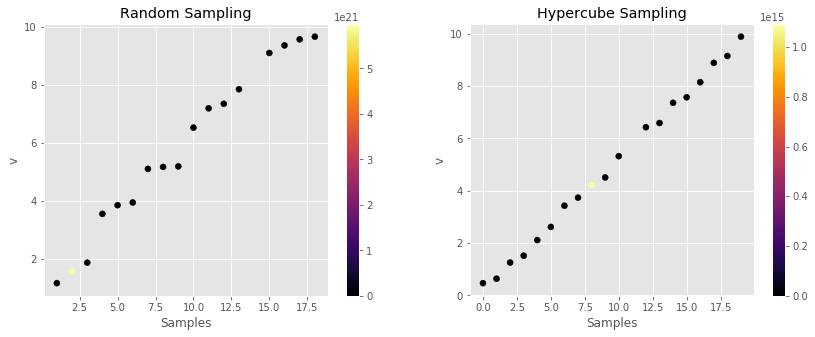

D


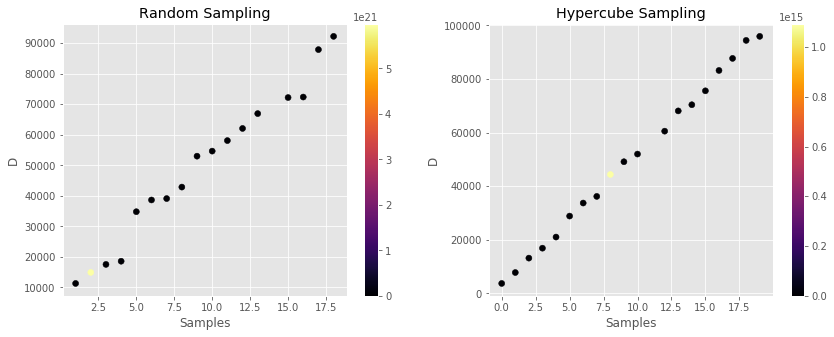

ftt


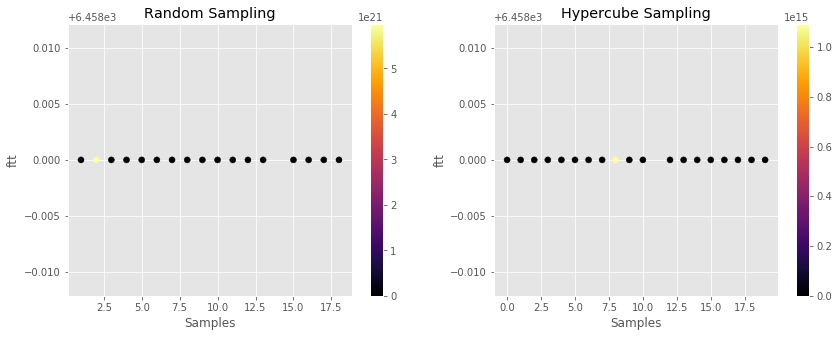

In [159]:
for key, val in param_config.items():
    fig, axs = plt.subplots(1,2, figsize=(
        14, 5), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    print(key)
    samples = [samp[key] for samp in sample_list]
    samples.sort()
    cm0 = axs[0].scatter(list(range(len(samples))), samples, c=sample_misfit_list, cmap="inferno")
    axs[0].set_xlabel("Samples")
    axs[0].set_ylabel(key)
    axs[0].set_title("Random Sampling")
    fig.colorbar(cm0, ax=axs[0])
    
    hyp_samples = [samp[key] for samp in hyp_sample_list]
    hyp_samples.sort()
    cm1 = axs[1].scatter(list(range(len(hyp_samples))), hyp_samples, c=hyp_sample_misfit_list, cmap="inferno")
    axs[1].set_xlabel("Samples")
    axs[1].set_title("Hypercube Sampling")
    axs[1].set_ylabel(key)
    fig.colorbar(cm1, ax=axs[1])
    
    
    plt.show()

[]


IndexError: Cannot choose from an empty sequence